# Song Recommendation Project - User Survey Results
### Justin Gong | June 2023 - July 2023

This notebook takes and draws conclusions from user surveys to determine metrics for my model. This is done through data visualizations and direct analysis of tables. This notebook will be divided into two parts: **pre-user survey** and **final system user review**. These two sections can be found based on the headers in this notebook.

NOTE: The pre-user survey section was completed **prior** to developing the system in main_notebook.ipynb. The final system user review section was completed **after** developing the recommendation system. 

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

/Users/justingong/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Pre-User Survey

Prior to beginning this project, I brainstormed potential variables in determining how songs would be recommended, independent of social network analysis (user-based recommendation systems that rely on actions of similar users) due to lack of data. I designed a pre-survey for users to take to determine what are the most important features to my audience. Due to the structure of the surveying, the results are indicative of **young adults** residing in **New Jersey.** The information below should be taken into account: 

1. This was conducted through a digital Google Forms survey, as attached in the GitHub repository 
2. 45 users were selected to answer the survey, which is large enough to draw generalized statistical conclusions 
3. The integrity of selection was *NOT* random, as users were hand-picked myself. Therefore, this introduces potential bias in the answers and must be taken into consideration when drawing conclusions
4. Users were instructed to try to select 1 or 5 at least once to avoid neutral results.

The following are the questions on the survey:

- Q1 - Importance of similar audio features
- Q2 - Importance of popularity
- Q3 - Importance of genre
- Q4 - Importance of time period 
- Q5 - Importance of similar artists 
- Q6 - Importance of proportionalizing artists
- Q7 - Importance of lyric similarity

Each of the values represent importance on a scale of 1-5, with 1 being no importance and 5 most extremely important.

In [4]:
presurvey = pd.read_csv("data/user_presurvey_results.csv")

In [6]:
presurvey.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7
0,4,1,5,2,5,1,1
1,3,2,4,1,3,3,2
2,5,3,3,1,4,5,3
3,2,3,4,1,2,2,1
4,5,4,4,1,5,4,1


This table **(previously cleaned in Excel)** displays the answers for a given user and question. 

Text(0.5, 0, 'Question')

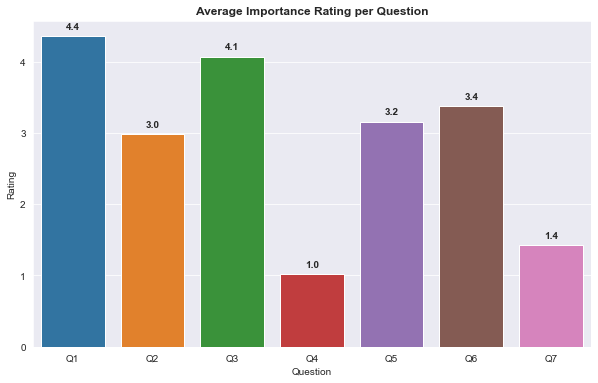

In [64]:
sns.set_style("darkgrid")
plt.figure(figsize = (10, 6))
ax = sns.barplot(data = presurvey, 
                 ci = None)

for x in ax.patches:
    ax.annotate(format(x.get_height(), '.1f'),
                (x.get_x() + x.get_width() / 2., x.get_height()),
                ha = 'center', 
                va = 'bottom',
                xytext = (0, 5), 
                textcoords='offset points',
                weight = 'bold')

plt.title("Average Importance Rating per Question", weight = 'bold')
plt.ylabel("Rating")
plt.xlabel("Question")

From this, we can see that question 1 and question 3 are the most important features. This tells us that users prefer for their recommended songs to have similar audio features and be the same genre. This tells us that the **type** of song is the utmost important variable in determining the songs. However, we can see that other aspects such as similar artists and popularity is also important.

Next, we'll analyze the distribution of questions for ratings of 5 and ratings of 1:

In [36]:
presurvey_pivot = pd.melt(presurvey).pivot_table(index = "value", columns = "variable", aggfunc = "size", fill_value = 0)

In [37]:
presurvey_pivot

variable,Q1,Q2,Q3,Q4,Q5,Q6,Q7
value,,,,,,,
1,1,2,0,44,1,1,30
2,1,4,0,1,3,3,12
3,5,33,3,0,32,21,2
4,12,5,36,0,6,18,1
5,26,1,6,0,3,2,0


We can see the distribution of distribution of the answers clearly using the above table. Immediately, it is apparent that question 4 is not important to most users, that being the recommended song occuring in the same year/approximately the same year.

Text(0.5, 1.0, 'Distribution of Questions Receiving 5')

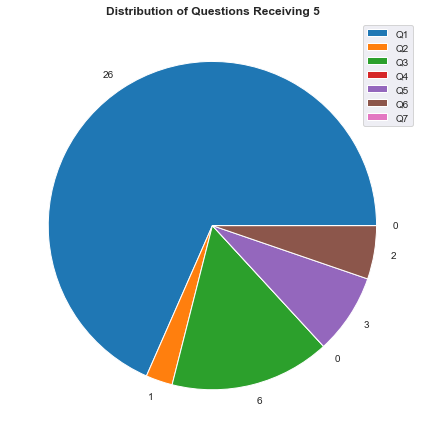

In [63]:
plt.figure(figsize = (10, 6))
plt.pie(presurvey_pivot.iloc[4], labels = presurvey_pivot.iloc[4].values)
plt.legend(labels = presurvey_pivot.iloc[4].index)
plt.tight_layout()
plt.title("Distribution of Questions Receiving 5", weight = 'bold')

Text(0.5, 1.0, 'Distribution of Questions Receiving 1')

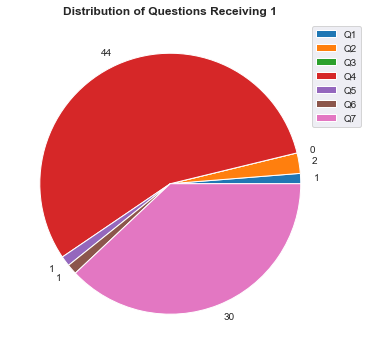

In [75]:
plt.figure(figsize = (10, 6))
plt.pie(presurvey_pivot.iloc[0], labels = presurvey_pivot.iloc[0].values)
plt.legend(labels = presurvey_pivot.iloc[0].index, loc = 'upper right', bbox_to_anchor = (1.1, 1))
plt.title("Distribution of Questions Receiving 1", weight = 'bold')

From these distributions, we may completely omit 4 and 7 from the metrics in my recommendation system (Time period and lyric similarity). We can also see that audio features is the most important feature, therefore we need a system that can find the most similar songs based on audio features and prioritize that information as part of the calculation.

Therefore, we currently have the following metrics for our recommendation system: **audio features**, **popularity**, **genres**, and **artists**. Since audio features and popularity are measured numerically, we will first analyze these two categories to determine how to calculate a *base* recommendation score. Since genre and artists are categorical and more difficult to "formulate" into a recommendation score, we will approach this separately from audio features and popularity score. We will address this once we analyze the other two categories.

### Analysis of Audio Features and Popularity

First, we need to decide how to distribute the recommendation score based on the audio features and the popularity. Since the popularity is scored out of 100 points on the spotify API, we will measure similarity of audio features on a scale of 100 as well, and decide the weightage of both categories. This will be done by comparing the importance of these two specific categories for users.

In [81]:
presurvey['Q1'].sum() / presurvey[['Q1', 'Q2']].sum().sum()

0.593939393939394

In [82]:
presurvey['Q2'].sum() / presurvey[['Q1', 'Q2']].sum().sum()

0.40606060606060607

It appears that of the two ratings, 60% is held by audio features and 40% is held by popularity. Let's further analyze the distribution by only looking at ratings above a 3, which signifies the extent which users see the feature as important (Since 3 is considered neutral). 

In [85]:
presurvey['Q1'][presurvey['Q1'] > 3].sum()

178

In [86]:
presurvey['Q2'][presurvey['Q2'] > 3].sum()

25

In [87]:
178 / (178 + 25)

0.8768472906403941

Now we can see that if we limit the analysis to only ratings above 3, there is significantly more weight held by the audio features category. We can also see this through the pivot table above, as the primary rating for audio features was 5 but the primary rating for popularity is 3. Therefore, due to the results we see in these two sections, we can have popularity hold **20%** of the recommendation score and audio feature similarity hold **80%** of the recommendation score for the base.

### Analysis of Genres and Artists

As mentioned earlier, we cannot measure audio features and popularity the same as overlapping genres and artists, as these cannot be directly measured numerically. In order to determine it's weightage and how to determine its contribution to the recommendation score, we may visualize the pivot table constructed earlier. 

In [91]:
presurvey_pivot[[]]

variable,Q1,Q2,Q3,Q4,Q5,Q6,Q7
value,,,,,,,
1,1,2,0,44,1,1,30
2,1,4,0,1,3,3,12
3,5,33,3,0,32,21,2
4,12,5,36,0,6,18,1
5,26,1,6,0,3,2,0


Text(0.5, 1.0, 'Line Plot of User Ratings per Question')

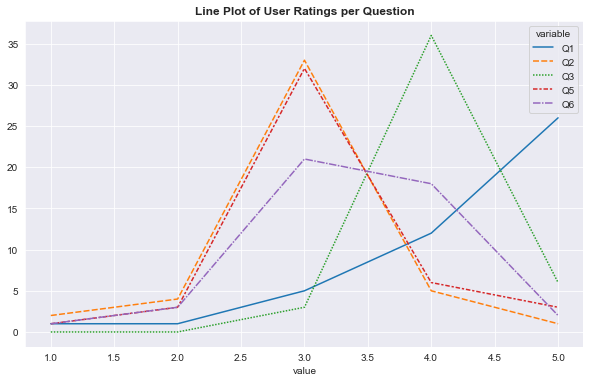

In [92]:
plt.figure(figsize=(10, 6))
sns.lineplot(data = presurvey_pivot[['Q1', 'Q2', 'Q3', 'Q5', 'Q6']])
plt.title("Line Plot of User Ratings per Question", weight = 'bold')

As we can see from the line plot above, there is a fairly similar distribution between popularity and overlapping artists, both with primarily ratings of 3. Therefore, we know that the **maximum** contribution that overlapping artists can have on the recommendation score is **0.2**. This is because the maximum amount of contribution that popularity can have on the recommendation score is **0.2**, if that song has a popularity score of 100 on the Spotipy API. 

However, it is also important to note that the popularity contribution is proportional to the popularity score. Therefore, the amount of overlapping artists should be proportional to the contribution. Especially since question 6 has an average rating 3.4, which indicates that users do care about this proportionality. This means that if a potential song is made by an artist that only occurs once in the playlist, it should not have a large contribution, but if this artist occurs many times in the playlist, it should be have a higher recommendation score. Therefore, we will create a system that will proportionally contribute based on the amount of artist overlap in the playlist, with a maximum contribution of 0.2.

Text(0.5, 1.0, 'Importance Rating Share Between Q3 and Q5')

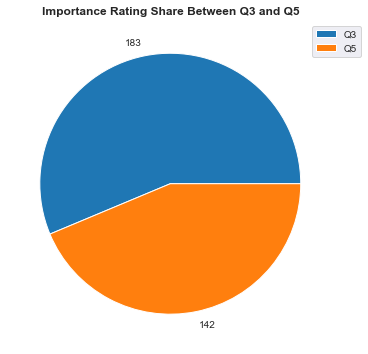

In [113]:
plt.figure(figsize = (10, 6))
plt.pie(presurvey_pivot[['Q3', 'Q5']].apply(lambda row: row * row.name, axis = 1).sum(), labels = presurvey_pivot[['Q3', 'Q5']].apply(lambda row: row * row.name, axis = 1).sum())
plt.legend(labels = ['Q3', 'Q5'], loc = 'upper right', bbox_to_anchor = (1.1, 1))
plt.title("Importance Rating Share Between Q3 and Q5", weight = 'bold')

As we can see by comparing the importance ratings between Q3 and Q5 (importance of genre vs artist respectively), having the same genre is slightly more important to users than have the same artists. Therefore, we will use a similar system in measuring the contribution of genre, but instead, have a maximum contribution of **0.25**. 

## Final Takeaways

1. Audio feature similarity is the most important feature according to users, and should be the main focus of the project 
2. Audio feature similarity may be 80% of the base recommendation score and popularity may be the other 20% 
3. Overlapping artists may contribute at most an additional 0.2 points, being proportional to the occurence of the overlapping artist in the playlist 
4. Overlapping genres may contribute at most an additional 0.25 points, being proportional to the occurence of the overlapping genre in the playlist

# Final Recommendation System User Review

At the end of the project, I had users test the final recommendation system with a playlist of their choice. I designed a survey to gather reviews from users to retrieve measureable performance metrics and feedback for future improvements. Due to the structure of sampling, it is important to note that these results are primarily restricted to **young adults** residing in **New Jersey**. The information below should also be taken into account:

1. This was conducted digitally via a Google Forms survey, which can be found on the GitHub repository 
2. 48 users were selected for user feedback, which statistically significant to draw conclusions on the general population
3. The integrity of the sampling was NOT random, as users hand-picked myself. Therefore, this introduces potential bias in the answers 
4. Users were instructed to *intentionally* pick a playlist that has a "significant and detectable theme/mood/genre" for the best model performance. 
    a. This is due to the model relying on the songs in the playlist having an overarcing "theme" to produce similar audio features 
5. Users from previous surveys (Such as the presurvey) were surveyed once again. This may cause bias in the performance evaluation as the model construction was based on the presurvey answers.

Below are the four questions that were asked to users on this survey:

- Q1: What was the general category of your playlist? 
- Q2: From 1-100%, what proportions of the songs would you say were successful recommendations?
- Q3: From 1-5, how would you rate the performance of the model overall? 
- Q4: What was the biggest reason why songs were unsuccessfully recommended?

For Q1:
- 0: Acoustic
- 1: Slow
- 2: Upbeat
- 3: Calm 
- 4: Energetic 

For Q4: 
- 0: Disliked song but matched audio features
- 1: Inaccurate genre
- 2: Inaccurate audio features
- 3: Unpopular 
- 4: All recommendations were successful

In [114]:
user_review = pd.read_csv("data/final_survey_data.csv")

In [116]:
user_review.head()

,Q1,Q2,Q3,Q4
0,2,70,5,2
1,3,80,4,2
2,1,55,4,2
3,2,75,4,2
4,2,65,4,1


**NOTE**: Dataset was preprocessed and cleaned in *Excel* prior to CSV download. This is the cleaned version being used.

First, let's observe the distribution of the categories which users selected:

Text(0.5, 0, 'Category')

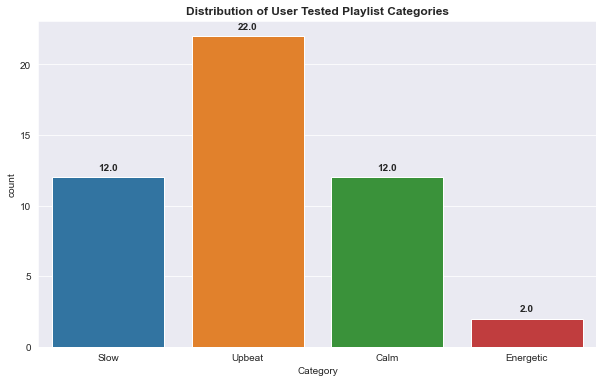

In [148]:
plt.figure(figsize = (10, 6))
x_value_mapping = {0: "Slow", 1: "Upbeat", 2: "Calm", 3: "Energetic"}
ax = sns.countplot(x = 'Q1', data = user_review)
ax.set_xticklabels([x_value_mapping[x] for x in ax.get_xticks()])
for x in ax.patches:
    ax.annotate(format(x.get_height(), '.1f'),
                (x.get_x() + x.get_width() / 2., x.get_height()),
                ha = 'center', 
                va = 'bottom',
                xytext = (0, 5), 
                textcoords='offset points',
                weight = 'bold')
plt.title("Distribution of User Tested Playlist Categories", weight = 'bold')
plt.xlabel("Category")

We can see that upbeat music was the most popular playlist type that was tested on, whereas "energetic" playlists were not chosen. This may be because of confusion in the difference between upbeat and energetic. Additionally, there were no playlists that were purely categorized as "acoustic". 

Next, we'll look at the general performance metrics:

In [155]:
pd.DataFrame(user_review.mean()[['Q2', 'Q3']], columns = ['Average'])

,Average
Q2,73.333333
Q3,4.395833


From the dataframe above, we can see that the recommendation system received a **4.4/5** rating from users with an approximately **73%** success rate in recommendations. Now, let's analyze the specific performances based on the categories which users selected for their playlist.

In [164]:
user_review['Q1'] = user_review['Q1'].map({1: 'Slow', 2: 'Upbeat', 3: 'Calm', 4: 'Energetic'})

In [181]:
user_review.groupby('Q1').mean()[['Q2', 'Q3']]

,Q2,Q3
Q1,,
Calm,80.000000,4.166667
Energetic,65.000000,4.000000
Slow,69.166667,4.416667
Upbeat,72.727273,4.545455


Text(0, 0.5, '% Successful Recommendations')

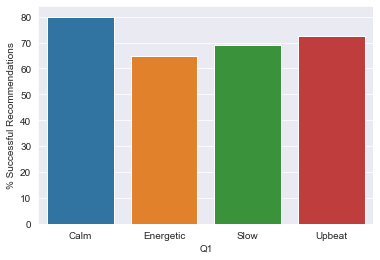

In [203]:
sns.barplot(x=user_review.groupby('Q1').mean()[['Q2', 'Q3']].index, y='Q2', data=user_review.groupby('Q1').mean()[['Q2', 'Q3']])
plt.ylabel("% Successful Recommendations")

We can see from the information above that each category performed well, but energetic playlists were particularly underperforming in comparison. We can see that calm and slow songs did very well, perhaps because the recommendation system is able to interpret slower audio features easier. Regardless, upbeat songs also did very well according to users.

Finally, let's analyze the reason why users may be unhappy with the recommendation system: 

Text(0.5, 1.0, 'Distribution of Largest Mistakes According to Users')

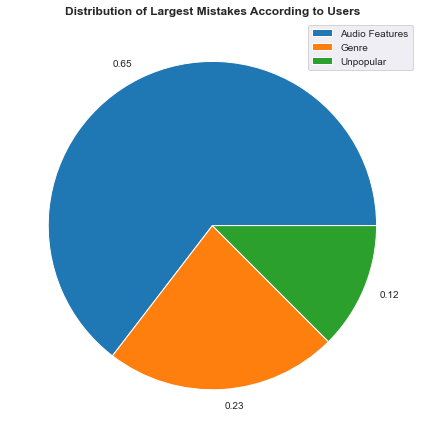

In [202]:
plt.figure(figsize = (10, 6))
plt.pie(user_review['Q4'].value_counts(), labels = round(user_review['Q4'].value_counts() / len(user_review), 2))
plt.legend(['Audio Features', 'Genre', 'Unpopular'])
plt.tight_layout()
plt.title("Distribution of Largest Mistakes According to Users", weight = 'bold')

We can see according to users, audio features is the biggest reason why they would classify a recommendation as unsuccessful. Upon reading long answer responses, users say that certain songs sound completely irrelevant to the theme of the playlist. Even though it may be the same genre and a song that they may like, it is very different from the intended theme. This could be due to Spotify's classification of audio features being incorrect, causing the model to deem it as a similar song. However, users claim that most songs fit the theme of the playlist, with just a few songs sounding random. 

**Final Takeaways**

1. Overall, the final recommendation system received very good reviews with a 4.5 average rating and 75% success rate
2. There is still a lot of bias in the survey due to a non-random sampling and a prior relationship with the users, which may result in positive bias 
3. Slower and calmer songs tend to perform better in finding similar songs using kNN
4. Certain songs that are retrieved from the Spotipy API do not have similar audio features despite being retrieved 
5. Results are primarily conclusive for playlists that have a particular theme